# Basic SHAP Interaction Value Example in XGBoost

This notebook shows how the SHAP interaction values for a very simple function are computed. We start with a simple linear function, and then add an interaction term to see how it changes the SHAP values and the SHAP interaction values.

In [1]:
import xgboost as xgb
import numpy as np
import shap

## Explain a linear function with no interactions

In [2]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1
X[:500,1] = 1
X[1000:1500,1] = 1
X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1
y = 2* X[:,0] - 3 * X[:,1]

In [3]:
# ensure the variables are independence
np.cov(X.T)

array([[ 0.25012506,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.25012506,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.25012506,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [4]:
# train a model with single tree
Xd = xgb.DMatrix(X, label=y)
model = xgb.train({
    'eta':1, 'max_depth':3, 'base_score': 0, "lambda": 0
}, Xd, 1)
print(model.get_dump(with_stats=True)[0])

0:[f1<0.5] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0.5] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:leaf=-0,cover=500
		4:leaf=2,cover=500
	2:[f0<0.5] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:leaf=-3,cover=500
		6:leaf=-1,cover=500



In [5]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
shap_values = model.predict(Xd, pred_contribs=True)
np.abs(shap_values.sum(1) - pred).max()

0.0

If we build a summary plot we see that only features 1 and 2 have any effect, and that their effects only have two possible magnitudes (one for 0 and for 1).

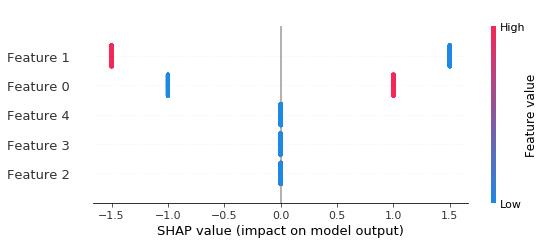

In [6]:
shap.summary_plot(shap_values, X)

In [7]:
shap_values[0]

array([ 1. , -1.5,  0. ,  0. ,  0. , -0.5], dtype=float32)

In [8]:
# Make sure the computed SHAP values match the true SHAP values
# (we can compute the true SHAP values directly for this simple case)
true_shap_values = np.zeros(shap_values.shape)
true_shap_values[:,-1] = y.mean()
true_shap_values[:,0] = 2. * (X[:,0] - X[:,0].mean())
true_shap_values[:,1] = -3. * (X[:,1] - X[:,1].mean())
np.abs((true_shap_values - shap_values)).sum()

0.0

### SHAP Interaction Values

Note that when there are no interactions present the SHAP interaction values are just a diagonal matrix with the SHAP values on the diagonal.

In [9]:
intr = model.predict(Xd, pred_interactions=True)
intr[0]

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -1.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.5]], dtype=float32)

## Explain a linear model with one interaction

In [10]:
# simulate some binary data and a linear outcome with an interaction term
# note we make the features in X perfectly independent of each other to make
# it easy to solve for the exact SHAP values
N = 2000
X = np.zeros((N,5))
X[:1000,0] = 1

X[:500,1] = 1
X[1000:1500,1] = 1

X[:250,2] = 1
X[500:750,2] = 1
X[1000:1250,2] = 1
X[1500:1750,2] = 1

X[:125,3] = 1
X[250:375,3] = 1
X[500:625,3] = 1
X[750:875,3] = 1
X[1000:1125,3] = 1
X[1250:1375,3] = 1
X[1500:1625,3] = 1
X[1750:1875,3] = 1
y = 2* X[:,0] - 3 * X[:,1] + 2 * X[:,2] * X[:,3]

In [11]:
# train a model with single tree
Xd = xgb.DMatrix(X, label=y)
model = xgb.train({
    'eta':1, 'max_depth':4, 'base_score': 0, "lambda": 0
}, Xd, 1)
print(model.get_dump(with_stats=True)[0])

0:[f1<0.5] yes=1,no=2,missing=1,gain=4500,cover=2000
	1:[f0<0.5] yes=3,no=4,missing=3,gain=1000,cover=1000
		3:[f2<0.5] yes=7,no=8,missing=7,gain=125,cover=500
			7:leaf=-0,cover=250
			8:[f3<0.5] yes=15,no=16,missing=15,gain=250,cover=250
				15:leaf=-0,cover=125
				16:leaf=2,cover=125
		4:[f2<0.5] yes=9,no=10,missing=9,gain=125,cover=500
			9:leaf=2,cover=250
			10:[f3<0.5] yes=17,no=18,missing=17,gain=250,cover=250
				17:leaf=2,cover=125
				18:leaf=4,cover=125
	2:[f0<0.5] yes=5,no=6,missing=5,gain=1000,cover=1000
		5:[f2<0.5] yes=11,no=12,missing=11,gain=125,cover=500
			11:leaf=-3,cover=250
			12:[f3<0.5] yes=19,no=20,missing=19,gain=250,cover=250
				19:leaf=-3,cover=125
				20:leaf=-1,cover=125
		6:[f2<0.5] yes=13,no=14,missing=13,gain=125,cover=500
			13:leaf=-1,cover=250
			14:[f3<0.5] yes=21,no=22,missing=21,gain=250,cover=250
				21:leaf=-1,cover=125
				22:leaf=1,cover=125



In [12]:
# make sure the SHAP values add up to marginal predictions
pred = model.predict(Xd, output_margin=True)
shap_values = model.predict(Xd, pred_contribs=True, approx_contribs=False)
np.abs(shap_values.sum(1) - pred).max()

4.7683716e-07

If we build a summary plot we see that now only feature 4 does not matter, and that features 2 and 3 can have four possible effect sizes since they interact with one another.

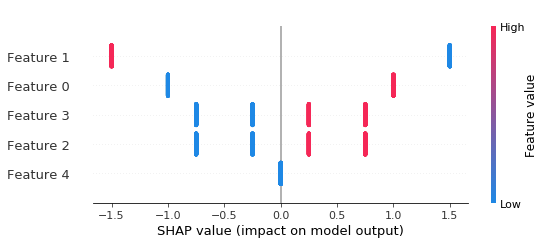

In [13]:
shap.summary_plot(shap_values, X)

In [14]:
true_interactions = np.zeros((X.shape[0],X.shape[1]+1,X.shape[1]+1))
for i in range(X.shape[0]):
    x = X[i,:]
    a = y[X[:,2] == x[2]].mean() - y.mean()
    b = y[(X[:,3] == x[3]) * (X[:,2] == x[2])].mean() - y[(X[:,3] == x[3])].mean()
    true_interactions[i,2,3] = b - a
    
    a = y[(X[:,3] == x[3])].mean() - y.mean()
    b = y[(X[:,2] == x[2]) * (X[:,3] == x[3])].mean() - y[(X[:,2] == x[2])].mean()
    true_interactions[i,3,2] = b - a
interaction_diag = shap_values - true_interactions.sum(2)
for i in range(X.shape[0]):
    true_interactions[i] += np.diag(interaction_diag[i])

In [15]:
true_interactions[0].round(3)

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -1.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [16]:
# SHAP interaction contributions:
intr = model.predict(Xd, pred_interactions=True)
intr[0].round(3)

array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-0.  , -1.5 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]], dtype=float32)

If we build a dependence plot for feature 0 we that it only takes two values and that these values are entirely dependent on the value of the feature (the value of feature 0 entirely determines it's effect because it has no interactions with other features).

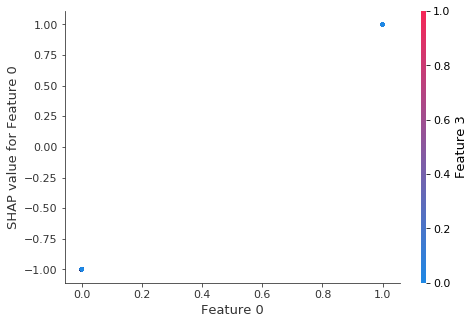

In [17]:
shap.dependence_plot(0, shap_values, X)

In contrast if we build a dependence plot for feature 2 we see that it takes 4 possible values and they are not entirely determined by the value of feature 2, instead they also depend on the value of feature 3. This vertical spread in a dependence plot represents the effects of non-linear interactions.

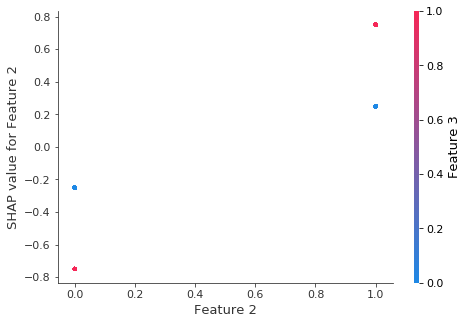

In [18]:
shap.dependence_plot(2, shap_values, X)